In [61]:
import pandas as pd
import os
from timezonefinderL import TimezoneFinder
from datetime import datetime
from zoneinfo import ZoneInfo
import pytz
import numpy as np
import matplotlib.pyplot as plt

# Getting file directory
base_dir = os.getcwd()

# Creating instance of TimezoneFinder (using timezoneFinder light)
tf = TimezoneFinder()

# Load IATA to ICAO/Latitude/Longitude mapping
iata_icao = pd.read_csv(base_dir+"\\iata-icao.csv")
iata_to_icao = dict(zip(iata_icao["iata"], iata_icao["icao"]))
iata_to_latitude = dict(zip(iata_icao["iata"], iata_icao["latitude"]))
iata_to_longitude = dict(zip(iata_icao["iata"], iata_icao["longitude"]))

# Load sample Transtats data
tnst_data = pd.concat([
    pd.read_csv(base_dir+"\\..\\transtats_data\\T_ONTIME_REPORTING_"+str(i)+".csv",
                     dtype={"CRS_DEP_TIME": str}) # changing dep to string to keep leading zeros
    for i in range(36,108) # [36-83] 2013-2016 Training Data Set, [84-107] 2017-2018 Testing Data Set
], 
ignore_index=True)

# Fill NA values in WEATHER_DELAY with 0
tnst_data["WEATHER_DELAY"] = tnst_data["WEATHER_DELAY"].fillna(0)

# Adding ICAO/Latitude/Longitude columns using maps
tnst_data["ICAO"] = tnst_data["ORIGIN"].map(iata_to_icao)
tnst_data["LATITUDE"] = tnst_data["ORIGIN"].map(iata_to_latitude)
tnst_data["LONGITUDE"] = tnst_data["ORIGIN"].map(iata_to_longitude)

tnst_data = tnst_data[tnst_data["ICAO"]=="KBNA"]
tnst_data.reset_index(drop=True, inplace=True)

# Adding timezone and removing non K icao's (non US)
tnst_data["LOCAL_TIMEZONE"] = tnst_data.apply(
    lambda row: tf.timezone_at(lat=row["LATITUDE"], lng=row["LONGITUDE"]),
    axis=1
)

# Building timezone object dictionary (for efficiency)
unique_tzs = tnst_data["LOCAL_TIMEZONE"].unique()
tz_dict = {tz: ZoneInfo(tz) for tz in unique_tzs}

# Generating UTC timezone column
tnst_data["UTC_TIMEZONE"] = tnst_data.apply(
    lambda row: datetime.strptime(row["FL_DATE"].split()[0]+" "+row["CRS_DEP_TIME"][0:2]+":"+row["CRS_DEP_TIME"][2:], 
                      "%m/%d/%Y %H:%M").replace(tzinfo=tz_dict[row["LOCAL_TIMEZONE"]]).astimezone(pytz.UTC),
    axis=1
)

# Routine Cleanup
tnst_data.dropna(inplace=True) 
tnst_data.reset_index(drop=True, inplace=True)

# Displaying basic cleanup results
print(tnst_data.head())

                FL_DATE ORIGIN CRS_DEP_TIME  WEATHER_DELAY  ICAO  LATITUDE  \
0  1/1/2013 12:00:00 AM    BNA         0530            0.0  KBNA   36.1245   
1  1/1/2013 12:00:00 AM    BNA         0546            0.0  KBNA   36.1245   
2  1/1/2013 12:00:00 AM    BNA         0600            0.0  KBNA   36.1245   
3  1/1/2013 12:00:00 AM    BNA         0600            0.0  KBNA   36.1245   
4  1/1/2013 12:00:00 AM    BNA         0605            0.0  KBNA   36.1245   

   LONGITUDE   LOCAL_TIMEZONE              UTC_TIMEZONE  
0   -86.6782  America/Chicago 2013-01-01 11:30:00+00:00  
1   -86.6782  America/Chicago 2013-01-01 11:46:00+00:00  
2   -86.6782  America/Chicago 2013-01-01 12:00:00+00:00  
3   -86.6782  America/Chicago 2013-01-01 12:00:00+00:00  
4   -86.6782  America/Chicago 2013-01-01 12:05:00+00:00  


NUMBER OF ROWS WITH DELAYS:  3353


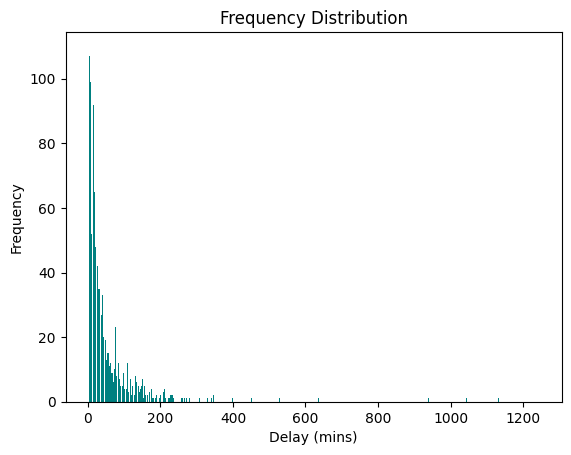

CUSTOM_BINS:  [  0   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85
  90  95 100 105 110 115 120 125]


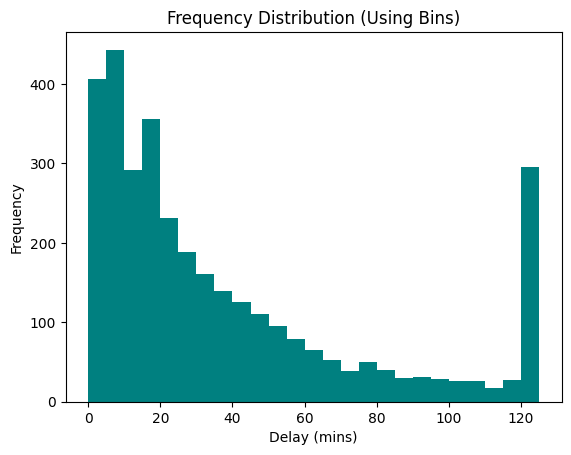

In [ ]:
# -------------------------------------------------
# Checking Number of delay data
# -------------------------------------------------

# Copying data
tnst_copy = tnst_data.copy(deep=True)

# Dropping non delay data
tnst_copy.loc[tnst_copy["WEATHER_DELAY"] == 0, ["WEATHER_DELAY"]] = np.nan
tnst_copy.dropna(inplace=True) 
tnst_copy.reset_index(drop=True, inplace=True)

# Counting data avaliable
print("NUMBER OF ROWS WITH DELAYS: ", len(tnst_copy))

# Checking delay frequencies
delay_freq = pd.Series(tnst_copy["WEATHER_DELAY"]).value_counts().sort_index()
plt.bar(delay_freq.index, delay_freq.values, color="teal")
plt.xlabel("Delay (mins)")
plt.ylabel("Frequency")
plt.title("Frequency Distribution")
plt.show()

# Bucketizing delays
custom_bins = np.arange(0, 130, 5) # bins work like [0, 5), [5, 10), ...
tnst_copy["WEATHER_DELAY_CAPPED"] = tnst_copy["WEATHER_DELAY"].clip(upper=120)
print("CUSTOM_BINS: ", custom_bins)
plt.hist(tnst_copy["WEATHER_DELAY_CAPPED"], bins=custom_bins, color="teal")
plt.xlabel("Delay (mins)")
plt.ylabel("Frequency")
plt.title("Frequency Distribution (Using Bins)")
plt.show()



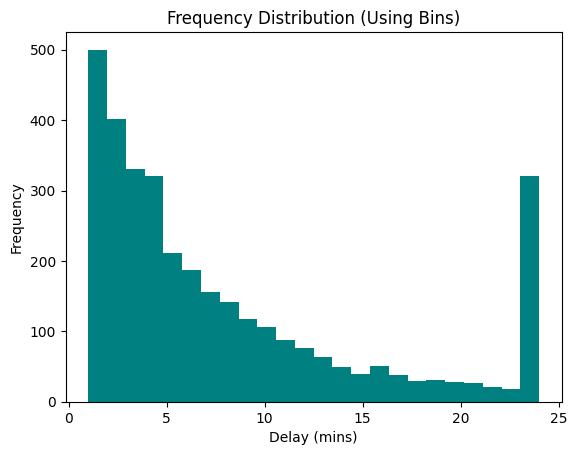

                FL_DATE ORIGIN CRS_DEP_TIME  WEATHER_DELAY  ICAO  LATITUDE  \
0  1/1/2013 12:00:00 AM    BNA         0530            0.0  KBNA   36.1245   
1  1/1/2013 12:00:00 AM    BNA         0546            0.0  KBNA   36.1245   
2  1/1/2013 12:00:00 AM    BNA         0600            0.0  KBNA   36.1245   
3  1/1/2013 12:00:00 AM    BNA         0600            0.0  KBNA   36.1245   
4  1/1/2013 12:00:00 AM    BNA         0605            0.0  KBNA   36.1245   

   LONGITUDE   LOCAL_TIMEZONE              UTC_TIMEZONE  YES_DELAY  DELAY_BIN  
0   -86.6782  America/Chicago 2013-01-01 11:30:00+00:00      False          0  
1   -86.6782  America/Chicago 2013-01-01 11:46:00+00:00      False          0  
2   -86.6782  America/Chicago 2013-01-01 12:00:00+00:00      False          0  
3   -86.6782  America/Chicago 2013-01-01 12:00:00+00:00      False          0  
4   -86.6782  America/Chicago 2013-01-01 12:05:00+00:00      False          0  


In [56]:
# Adding true/false delay column
tnst_data["YES_DELAY"] = tnst_data["WEATHER_DELAY"] > 0

# Adding bin delay column
tnst_data["DELAY_BIN"] = (np.where(
    tnst_data["WEATHER_DELAY"] == 0, 0,
    ((tnst_data["WEATHER_DELAY"]-1) // 5 + 1)
))
tnst_data["DELAY_BIN"] = tnst_data["DELAY_BIN"].clip(upper=24).astype(int)

# Visualizing to check correctness
plt.hist(tnst_data.loc[tnst_data["YES_DELAY"], ["DELAY_BIN"]], bins=24, color="teal")
plt.xlabel("Delay (mins)")
plt.ylabel("Frequency")
plt.title("Frequency Distribution (Using Bins)")
plt.show()

# Displaying results
print(tnst_data.head())

In [59]:
# Building Congestion Score Feature

# Getting training data set
tnst_train = tnst_data[:int(len(tnst_data)*0.75)]

# Building distribution of split between flights
train_time_splits = (tnst_train["UTC_TIMEZONE"].diff().dt.total_seconds().fillna(0) / 60)[1:]

# Building distribution & scoring delays
mu = np.mean(train_time_splits)
sigma = np.std(train_time_splits)


# Function to calculate the average split by a certain window size
def calc_avg_window_split(series, window_size):
    window_avgs = []

    for i in range(window_size, len(series)):
        window_splits = [series.iloc[i-j] for j in range(window_size)]
        window_avgs.append(np.mean(window_splits))
    return (np.array(window_avgs)).mean()

# Finding the best window size
window = 2
cur_diff = -1
while True:
    print("Trying Window: ", window)
    # Current average for window size
    cur_window_avg = calc_avg_window_split(train_time_splits, window)

    # Calculate distance from baseline
    diff_from_baseline = abs(mu-cur_window_avg)
    print("Difference from baseline: ", diff_from_baseline)
    # Checking if best window size
    if cur_diff == -1:
        cur_diff = diff_from_baseline
        window += 1
        continue
    elif diff_from_baseline < cur_diff:
        cur_diff = diff_from_baseline
        window += 1
        continue
    if not (window < 20):
        break
    window -= 1 # the previous window size was the best one
    break
    
print("Best window size found:", window)

# Creating global time splits
time_splits = (tnst_data["UTC_TIMEZONE"].diff().dt.total_seconds().fillna(0) / 60)


# Create congestion score
tnst_data["CONGESTION_SCORE"] = time_splits.rolling(window=window, min_periods=window).mean()

# CLeaning up new NaN caused by window
tnst_data.dropna(inplace=True) 
tnst_data.reset_index(drop=True, inplace=True)

# Showing Results
print(tnst_data.head())

Trying Window:  2
Difference from baseline:  2.2134293539366467e-05
Trying Window:  3
Difference from baseline:  1.8795721139497346e-06
Trying Window:  4
Difference from baseline:  1.3136794757784287e-05
Best window size found: 3
                FL_DATE ORIGIN CRS_DEP_TIME  WEATHER_DELAY  ICAO  LATITUDE  \
0  1/1/2013 12:00:00 AM    BNA         0600            0.0  KBNA   36.1245   
1  1/1/2013 12:00:00 AM    BNA         0600            0.0  KBNA   36.1245   
2  1/1/2013 12:00:00 AM    BNA         0605            0.0  KBNA   36.1245   
3  1/1/2013 12:00:00 AM    BNA         0620            0.0  KBNA   36.1245   
4  1/1/2013 12:00:00 AM    BNA         0630            0.0  KBNA   36.1245   

   LONGITUDE   LOCAL_TIMEZONE              UTC_TIMEZONE  YES_DELAY  DELAY_BIN  \
0   -86.6782  America/Chicago 2013-01-01 12:00:00+00:00      False          0   
1   -86.6782  America/Chicago 2013-01-01 12:00:00+00:00      False          0   
2   -86.6782  America/Chicago 2013-01-01 12:05:00+00:00   

In [ ]:
# Exporting cleaned data
# Copying columns from tnst_data to tnst_dt
tnst_dt = tnst_data.rename(columns={
    "UTC_TIMEZONE": "date",
    "ICAO": "icao",
    "WEATHER_DELAY": "weather_delay",
    "CONGESTION_SCORE": "congestion_score",
    "YES_DELAY": "yes_delay",
    "DELAY_BIN": "delay_bin"
})[["date", "icao", "weather_delay",
    "congestion_score", "yes_delay", "delay_bin"]].copy()

print(tnst_dt.head())
tnst_dt.to_csv("tnst_dt.csv", index=False)

                       date  icao  weather_delay  congestion_score  yes_delay  \
0 2013-01-01 12:00:00+00:00  KBNA            0.0         10.000000      False   
1 2013-01-01 12:00:00+00:00  KBNA            0.0         10.000000      False   
2 2013-01-01 12:05:00+00:00  KBNA            0.0          6.333333      False   
3 2013-01-01 12:20:00+00:00  KBNA            0.0          6.666667      False   
4 2013-01-01 12:30:00+00:00  KBNA            0.0         10.000000      False   

   delay_bin  
0          0  
1          0  
2          0  
3          0  
4          0  
